## Общее описание:

Задача – оценить, правда ли, что новый алгоритм улучшил качество сервиса приложения для онлайн-знакомств. 

Механика приложения следующая: пользователи видят в приложении анкеты друг друга и могут ставить друг другу лайки или дизлайки. Если пользователи поставили друг другу лайк – это называется 'мэтч', и у пользователей появляется возможность познакомиться.

Команда приложения разработала новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма был проведен A/B-тест. Все пользователи были разделены на две группы.

### Описание данных

В данных находится выгрузка логов взаимодействия пользователей друг с другом. Для каждой пары пользователей указано, из какой они группы A/B-теста и случился ли у них мэтч.

Результат работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему поиска анкет на всех пользователей.

- **user_id_1** – идентификационный номер пользователя 1
- **user_id_2** – идентификационный номер пользователя 2
- **group** - группа пользователя:
    - 0 - пользователь пользовался приложением со старым алгоритмом (контрольная группа)
    - 1 - пользователь пользовался приложением с новым алгоритмом (тестовая группа)
- **is_match** - случился ли мэтч:
    - 0 - не случился
    - 1 - случился

## План

1. **Сначала сделаем небольшой препроцессинг:**
    - Посмотрим на данные
2. **Проводим анализ:**
    - Выбираем метрики
    - Формулируем гипотезы
    - Строим графики
    - Выбираем подходящий тест
    - Тестируем
4. **Подводим итоги:**
    - Сформулируем выводы
    - Как можно будет позже провести A/B-тестирование?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, shapiro, kruskal, ttest_ind

sns.set(rc={'figure.figsize':(15, 5)}, style="whitegrid")

## Считывание и анализ данных

In [2]:
df = pd.read_csv('dating_data.csv')

In [3]:
df.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [4]:
df.shape

(14514, 4)

In [5]:
df.dtypes

user_id_1    int64
user_id_2    int64
group        int64
is_match     int64
dtype: object

In [6]:
df.nunique()

user_id_1    1000
user_id_2    1000
group           2
is_match        2
dtype: int64

In [7]:
df.isna().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

Посмотрим совпадают ли списки уникальных пользователей user_1 и user_2

In [8]:
sorted(df.user_id_2.unique()) == sorted(df.user_id_1.unique())

True

Списки пользователей user_1 и user_2 совпадают. Предположим, что в user_1 записаны пользователи, которые первыми поставили лайк или дизлайк, а в user_2 пользователи, которые принимали решение позже.

На всякий случай проверим есть ли пользователи, которые попали и в тестовую, и контрольную группы

In [9]:
any(np.in1d(df.query('group == 0').user_id_1.unique(), 
            df.query('group == 1').user_id_1.unique())) or any(np.in1d(df.query('group == 0').user_id_2.unique(),
                                                                       df.query('group == 1').user_id_2.unique()))

False

Посмотрим на количество уникальных пользователей в группах 0 и 1

In [10]:
df.groupby(['group'], as_index='group').agg(count_unique_users=('user_id_1', lambda x: np.size(x.unique())))

,count_unique_users
group,
0,501
1,499


Посмотрим на количество взаимодействий (лайков и дизлайков) в каждой группе

In [11]:
df.groupby('group', as_index='group')\
  .agg(interaction_count=('user_id_1', np.size))

,interaction_count
group,
0,4792
1,9722


Количество лайков и дизлайков в тестовой группе больше на 4930 (**103%**), чем в контрольной

Посмотрим на количество мэтчей в каждой группе

In [12]:
df.groupby(['group'], as_index='group')\
  .agg(match_count=('is_match', sum))

,match_count
group,
0,934
1,3909


Количество мэтчей в тестовой группе больше на 2975 (**318.5%**), чем в контрольной

Посмотрим, есть ли пользователи в данной выборке, у которых на данный момент не случилось ни одного мэтча

In [13]:
df.groupby(['group', 'user_id_1'], as_index=False)\
  .agg(count_match=('is_match', sum))\
  .query('count_match == 0')\
  .groupby('group', as_index='group')\
  .agg(count_users_not_match=('user_id_1', np.size))

,count_users_not_match
group,
0,79
1,1


В тестовой группе количество пользователей, у которых не случился мэтч составляет 1, в контрольной группе - 79.

## Выводы по анализу

- Списки пользователей user_1 и user_2 совпадают
- В тестовой группе 501 пользователь, в контрольной - 499
- Количество лайков и дизлайков в тестовой группе больше на 4930 (**103%**), чем в контрольной
- Количество мэтчей в тестовой группе больше на 2975 (**318.5%**), чем в контрольной
- В тестовой группе количество пользователей, у которых не случился мэтч составляет 1, в контрольной группе - 79.
- Делать выводы о том, улучшил ли качество новый алгоритм сервиса приложения для онлайн-знакомств еще рано, нужно выполнить статистический анализ.

## 2: Гипотезы и тесты

### Метрика LDC

Введём метрику количества взаимойдействий (*лайков/дизлайков*) на одного пользователя Likes/Dislikes Count (**LDC**)

Обозначим гипотезы:

- **H0** - Между выборками по метрике LDC нет статистически значимых различий
- **H1** - Между выборками по метрике LDC есть статистически значимые различия

В качестве уровня значимости **α** для всех тестов выберем значение **0.05**

Учитывая, что мы не знаем специфику приложения, а точнее в чем заключается различие между пользователями user_id_1 и user_id_2 будем проводить анализ для обеих групп пользователей. 

Посчитаем для каждого пользователя (и user_1, и user_2) в разбивке по группам общее количество взаимодействий.

In [14]:
df_metrics = df.groupby(['group', 'user_id_1'], as_index=False)\
               .agg(LDC_user_1=('is_match', 'count'))\
               .rename(columns={'user_id_1': 'user_id'})

df_LDC_user_2 = df.groupby(['group', 'user_id_2'], as_index=False).agg(LDC_user_2=('is_match', 'count'))

df_metrics = df_metrics.merge(df_LDC_user_2, 
                              left_on=['user_id', 'group'], 
                              right_on=['user_id_2', 'group'], 
                              how='inner', 
                              copy=False)\
                        .drop('user_id_2', axis=1)

Построим графики распредления **LDC**. 

*Учитывая, что нам понадобится визуализировать распределения других метрик, создадим фунцию построения необходимых графиков*

In [15]:
def show_plots(metric):
    '''Строит гистограмму и боксплоты распределения заданной метрики'''
    global df_metrics
    sns.set(style="ticks", font_scale=0.8)
    fig, axs = plt.subplots(2, 2)
    plt.subplots_adjust(hspace=0.7)
    for i in range(2):
        sns.histplot(data=df_metrics, x=f'{metric}_user_{i+1}', hue='group', kde=False, palette='YlOrBr', ax=axs[i, 0])
        axs[i, 0].set_title(f'Распределение {metric} для user_{i+1} в тестовой и контрольной группах')
        axs[i, 0].set_xlabel(f'{metric} для user_{i+1}')
        axs[i, 0].set_ylabel('Количество пользователей')
        axs[i, 0].tick_params(axis='both', which='both', labelsize=8)
        sns.boxplot(data=df_metrics, x ='group', y=f'{metric}_user_{i+1}', palette='YlOrBr', ax=axs[i, 1])
        axs[i, 1].set_title(f'Распределение {metric} для user_{i+1} в тестовой и контрольной группах')
        axs[i, 1].set_xlabel('Группа')
        axs[i, 1].set_ylabel(f'{metric} для user_{i+1}')
        axs[i, 1].tick_params(axis='both', which='both', labelsize=8)
    plt.show()

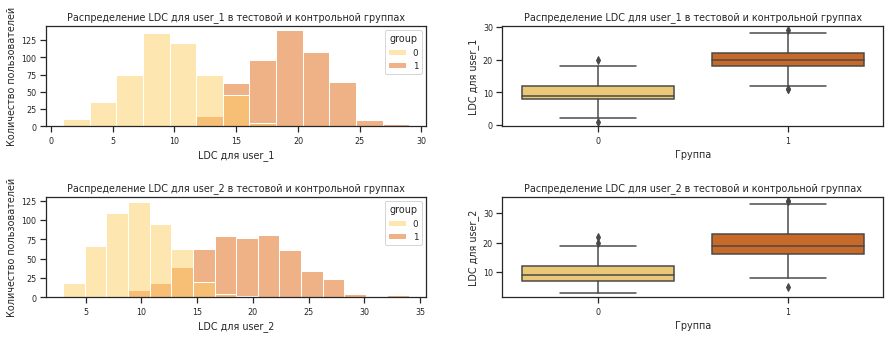

In [16]:
show_plots('LDC')

Из графиков видно, что в тестовой группе значение **LDC** увеличилось.

Для проверки на наличие статистически значимых различий в выборках, проверим распределения на нормальность с помощью критерия **Шапиро-Уилка**

*Далее придётся ещё проверять нормальность распределений, поэтому создадим функцию*

In [55]:
def normality_test(metric):
    global df_metrics
    print(f'p-value для проверки на нормальность распределения метрики {metric}:')
    print()
    for my_tuple in [(0, 1), (1, 1), (0, 2), (1, 2)]:
        num_group, num_user = my_tuple[0], my_tuple[1]  
        my_series = df_metrics.query(f'group == {num_group}')[f'{metric}_user_{num_user}']
        normality_pvalue = shapiro(my_series).pvalue
        if my_tuple == (0, 2):
            print()
        if num_group == 0:
            g = 'контрольной'
        else:
            g = 'тестовой'
        print(f'для user_{num_user} в {g} группе: {normality_pvalue}')

In [56]:
normality_test('LDC')

p-value для проверки на нормальность распределения метрики LDC:

для user_1 в контрольной группе: 0.00055683683604002
для user_1 в тестовой группе: 2.540682726248633e-05

для user_2 в контрольной группе: 8.998162570605928e-07
для user_2 в тестовой группе: 0.07568937540054321


Все распределения, кроме LDC для user_2 в тестовой группе статистически значимо отличаются от нормального распределения (p-value < 0.05), однако отличие от нормальности, на мой взгляд, небольшое, поэтому проверим наличие статистически значимых различий с помошью **U-теста Манна-Уитни** и **t-критерия**

In [19]:
a_user_1 = df_metrics.query('group == 0')['LDC_user_1']
b_user_1 = df_metrics.query('group == 1')['LDC_user_1']
a_user_2 = df_metrics.query('group == 0')['LDC_user_2']
b_user_2 = df_metrics.query('group == 1')['LDC_user_2']

In [20]:
# U-тест Манна-Уитни распределение метрики LCD для user_1
mannwhitneyu(a_user_1, b_user_1).pvalue

6.905154965510583e-157

In [21]:
# U-тест Манна-Уитни распределение метрики LCD для user_2
mannwhitneyu(a_user_2, b_user_2).pvalue

9.211614785731813e-142

In [22]:
# t-критерий распределение метрики LCD для user_1
ttest_ind(a_user_1, b_user_1).pvalue

1.8942877064043142e-285

In [23]:
# t-критерий распределение метрики LCD для user_2
ttest_ind(a_user_2, b_user_2).pvalue

7.515112760079062e-210

- Уровень значимости всех тестов ниже установленного уровня значимости **α** (*0.05*), что позволяет нам отвергнуть нулевую гипотезу H0.
- Между исследуемыми выборками (контрольной и тестовой групп) по метрике LDC есть статистически значимые различия.

Посмотрим как изменилась метрика LDC для user_1 и user_2 в тестовой группе по отношению к контрольной

In [57]:
def difference(metric):
    
    control_user_1 = df_metrics.query('group==0')[f'{metric}_user_1'].median()
    test_user_1 = df_metrics.query('group==1')[f'{metric}_user_1'].median()
    
    difference = test_user_1 - control_user_1
    percent_difference = round(((difference) / control_user_1) * 100, 2)
    
    print('Для user_1:', difference, percent_difference, '%')
    
    control_user_2 = df_metrics.query('group==0')[f'{metric}_user_2'].median()
    test_user_2 = df_metrics.query('group==1')[f'{metric}_user_2'].median()
    
    difference = test_user_2 - control_user_2
    percent_difference = round(((difference) / control_user_2) * 100, 2)
    
    print('Для user_2:', difference, percent_difference, '%')

In [58]:
difference('LDC')

Для user_1: 11.0 122.22 %
Для user_2: 10.0 111.11 %


Среднее (*median*) количество взаимодействий между пользователями в тестовой группе больше, чем в контрольной для user_1 на 11 (122%) для user_2 на 10 (111%)

### Метрика MC

Введём метрику количества мэтчей на одного пользователя Match Count (**MC**)

Обозначим гипотезы:

- **H0** - Между выборками по метрике MC нет статистически значимых различий
- **H1** - Между выборками по метрике MC есть статистически значимые различия

Уровень значимости **α** выберем 0.05

Посчитаем для каждого пользователя в разбивке по группам количество мэтчей

In [24]:
df_metrics['MC_user_1'] = df.groupby(['group', 'user_id_1'], as_index=False)\
                               .agg(MC_user_1=('is_match', sum))['MC_user_1']
df_MC_user_2 = df.groupby(['group', 'user_id_2'], as_index=False)\
                  .agg(MC_user_2=('is_match', sum))

df_metrics = df_metrics.merge(df_MC_user_2, 
                              left_on=['user_id', 'group'], 
                              right_on=['user_id_2', 'group'], 
                              how='inner', 
                              copy=False)\
                        .drop('user_id_2', axis=1)                               

Построим графики распредления **MC**

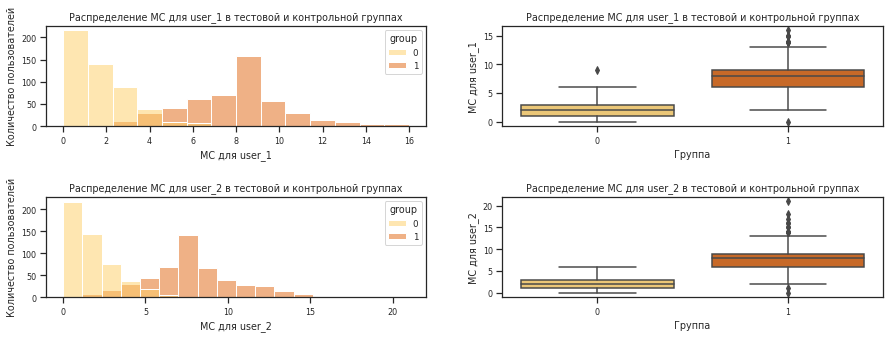

In [25]:
show_plots('MC')

Из графиков видно, что в тестовой группе значение **MC** увеличилось.

Для проверки на наличие статистически значимых различий, проверим распределения на нормальность с помощью критерия Шапиро-Уилка 

In [26]:
normality_test('MC')

p-value для проверки на нормальность распределения метрики MC:

для user_1 в контрольной группе: 1.1023814847670518e-16
для user_1 в тестовой группе: 1.0627190022205468e-05

для user_2 в контрольной группе: 2.661494516698851e-16
для user_2 в тестовой группе: 3.6622728316615394e-07


Распределения обеих групп не являются нормальными, поэтому будем использовать U-тест Манна-Уитни

In [27]:
a_user_1 = df_metrics.query('group == 0')['MC_user_1']
b_user_1 = df_metrics.query('group == 1')['MC_user_1']
a_user_2 = df_metrics.query('group == 0')['MC_user_2']
b_user_2 = df_metrics.query('group == 1')['MC_user_2']

In [28]:
# U-тест Манна-Уитни распределение метрики LCD для user_1
mannwhitneyu(a_user_1, b_user_1).pvalue

3.964683653930119e-155

In [29]:
# U-тест Манна-Уитни распределение метрики LCD для user_1
mannwhitneyu(a_user_2, b_user_2).pvalue

5.206195281157607e-151

- Уровень значимости ниже установленного уровня значимости **α** (0.05), что позволяет отвергнуть нулевую гипотезу H0.
- Между исследуемыми выборками: контрольной и тестовой групп есть статистически значимые различия метрики MC.

In [52]:
difference('MC')

Для user_1: 6.0 300.0 %
Для user_2: 6.0 300.0 %


Среднее (*median*) количество мэтчей на одного пользователя в тестовой группе больше, чем в контрольной на 6 (300 %)

### Метрика CMDL

Введём метрику отношения количества мэтчей к количеству взаимодействий (лайки/дизлайки) Conversion 
Matches to Dislikes/Likes (**CMDL**)

Обозначим гипотезы:

- **H0** - Между выборками по метрике CMDL нет статистически значимых различий
- **H1** - Между выборками по метрике CMDL есть статистически значимые различия

Уровень значимости **α** выберем 0.05

In [30]:
df_metrics['CMDL_user_1'] = df_metrics['MC_user_1'] / df_metrics['LDC_user_1']
df_metrics['CMDL_user_2'] = df_metrics['MC_user_2'] / df_metrics['LDC_user_1']

Построим графики распредления CMDL

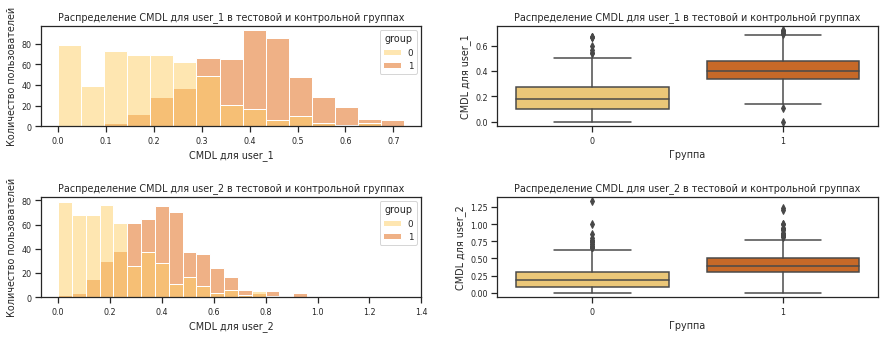

In [31]:
show_plots('CMDL')

Из графиков видно, что в тестовой группе значение **CMDL** увеличилось.

Для проверки на наличие статистически значимых различий, проверим распределения на нормальность с помощью критерия Шапиро-Уилка

In [32]:
normality_test('CMDL')

p-value для проверки на нормальность распределения метрики CMDL:

для user_1 в контрольной группе: 7.058642559343298e-11
для user_1 в тестовой группе: 0.2503166198730469

для user_2 в контрольной группе: 3.5452075970767334e-18
для user_2 в тестовой группе: 4.290019034458581e-11


Так как распределения **CMDL** в контрольной группе не является нормальным, в то время как в тестовой группе для user_1 распределение является нормальным, для сравнения этих групп мы снова применим **U-тест Манна-Уитни**. 

In [33]:
a_user_1 = df_metrics.query('group == 0')['CMDL_user_1']
b_user_1 = df_metrics.query('group == 1')['CMDL_user_1']
a_user_2 = df_metrics.query('group == 0')['CMDL_user_2']
b_user_2 = df_metrics.query('group == 1')['CMDL_user_2']

In [34]:
# U-тест Манна-Уитни распределение метрики CMDL для user_1
mannwhitneyu(a_user_1, b_user_1).pvalue

1.0739285895805636e-96

In [35]:
# U-тест Манна-Уитни распределение метрики CMDL для user_2
mannwhitneyu(a_user_2, b_user_2).pvalue

3.994780680429185e-66

- Уровень значимости ниже установленного уровня значимости **α** (0.05), что позволяет отвергнуть нулевую гипотезу H0 
- Между исследуемыми выборками: контрольной и тестовой групп есть статистически значимые различия.

In [53]:
difference('CMDL')

Для user_1: 0.2181818181818182 120.0 %
Для user_2: 0.20948616600790515 115.22 %


Отношение количества мэтчей к количеству взаимодействитй увеличилась в контрольной группе по сравнению с тестовой на 0.2 (115% - 120%)

### Вывод по проекту:

- В результате анализа выгрузки логов взаимодействия пользователей друг с другом можно сделать следующие выводы:
    - Количество взаимодействий между пользователями в тестовой группе больше, чем в контрольной для user_1 на 11 (122%) для user_2 на 10 (111%)
    - Количество мэтчей на одного пользователя в тестовой группе больше, чем в контрольной на 6 (300 %)
    - Отношение количества мэтчей к количеству взаимодействитй увеличилась в контрольной группе по сравнению с тестовой на 0.2 (115 - 120 %)
- Чтобы сделать выводы о генеральной совокупности, т.е. сказать, улучшает ли новый дизайн приложение, нужно узнать, репрезентативна ли выборка
- Для следующего A/B теста, чтобы точнее определить улучшает ли новый алгоритм качество сервиса предлагаю в базу данных добавить:
    - дату регистрации пользователя,
    - дату взаимодействия пользователя,
    - вид взаимодействий - лайк или дизлайк,
    - локацию (страна, город) пользователя, 
    - пол пользователя,
    - платформу устройства пользователя.